In [53]:
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
from dep_tools.grids import PACIFIC_EPSG
from fiona.io import ZipMemoryFile
from odc.geo.geom import Geometry
from odc.geo.xr import mask
from odc.stac import load
from pystac.client import Client
from xarray import DataArray, Dataset

In [54]:
site = "Ambae" 

In [55]:
aoi = gpd.read_file("priority_1_sites/"f"{site}.geojson")

In [57]:
bbox = aoi.to_crs("EPSG:4326")
bbox = Geometry(bbox.geometry.values[0], crs=bbox.crs)


In [59]:
# Get some seagrass data for the area
client = Client.open("https://stac.digitalearthpacific.org")
items = client.search(
    collections=["dep_s2_ammi"],
    intersects=bbox.json
).item_collection()

print(f"Found {len(items)} items")

Found 16 items


In [60]:
data = load(
    items,
    bands=["mangroves"],
    crs=PACIFIC_EPSG,  # 
    resolution=100,  # Change to 10 for full resolution,
    chunks={"x": 2048, "y": 2048}
)

# Convert data to 0 and 1, where 

data = data.mangroves != 255

data

<xarray.DataArray 'mangroves' (time: 8, y: 960, x: 1920)> Size: 15MB
dask.array<ne, shape=(8, 960, 1920), dtype=bool, chunksize=(1, 960, 1920), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 8kB -1.792e+06 -1.792e+06 ... -1.888e+06 -1.888e+06
  * x            (x) float64 15kB 1.896e+06 1.896e+06 ... 2.088e+06 2.088e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 64B 2017-01-01 2018-01-01 ... 2024-01-01

In [61]:
def xarray_calculate_area(
    data: Dataset | DataArray,
    geom: Geometry,
    variable: str | None = None,
    value: int | float | None = None,
) -> float:
    # Work with a dataarray, not a dataset, so it's a singular thing
    if type(data) is not DataArray:
        if variable is None:
            raise ValueError("Variable must be specified when data is a Dataset.")
        data = data[variable]

    # Only select a specific value. This will convert to float, with nans
    if value is not None:
        data = data.where(data == value)

    # Mask out regions outsize the geometry
    masked = mask(data, geom.to_crs(data.odc.crs))

    # Count all the non-nan cells, and multiply by area
    count = float(masked.notnull().sum().values)
    one_pixel_area = abs(
        masked.odc.geobox.resolution.x * masked.odc.geobox.resolution.y
    )

    return float(count) * one_pixel_area

In [68]:
# data

In [108]:
# Run the xarray_calculate_area per time step
results = []
for time in data.time:
    da = data.sel(time=time)
    area_m2 = xarray_calculate_area(da, bbox, variable="mangroves", value=1)
    # Year, in YYYY, area in m2, area in km2
    results.append({
        "time": pd.to_datetime(time.values).year,
        # "area_m2": area_m2,
        "ammi_ha": area_m2 / 10000
    })

df = pd.DataFrame(results)
df

,time,ammi_ha
0,2017,77.0
1,2018,119.0
2,2019,288.0
3,2020,253.0
4,2021,342.0
5,2022,432.0
6,2023,266.0
7,2024,355.0


In [106]:
# area_df = df.set_index('time')
# transposed_df = df.transpose()
# transposed_df.index.name = None
# transposed_df

In [110]:
df = transposed_df
df.columns.name = None
df.columns = df.columns.astype(int)
df.index.name = None
df

,0,1,2,3,4,5,6,7
time,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0
ammi_ha,77.0,119.0,288.0,253.0,342.0,432.0,266.0,355.0


In [112]:
# Assuming 'transposed_df' is the DataFrame resulting from the previous transpose

# 1. Select the 'time' row index level and use it to set the column headers.
#    We use .iloc[0] because 'time' is the first row of data in the transposed result.
df.columns = df.iloc[0]

# 2. Drop the original 'time' index row (which is now the column header)
#    and keep only the area data (which is the second row, index position 1).
df_clean = df.iloc[1:].copy()

# 3. Clean up the formatting and index names
df_clean.columns.name = None
df_clean.index.name = None

# 4. Convert the column headers (years) from float to integer
df_clean.columns = df_clean.columns.astype(int)

# 5. Display the final result
df_clean

,2017,2018,2019,2020,2021,2022,2023,2024
ammi_ha,77.0,119.0,288.0,253.0,342.0,432.0,266.0,355.0


<Axes: title={'center': 'Ambae'}, xlabel='time'>

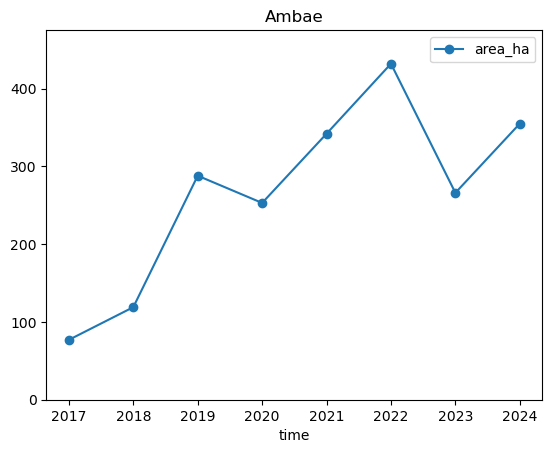

In [75]:
df.plot(x="time", y="area_ha", marker="o", title=site, ylim=(0, df["area_ha"].max() * 1.1))

In [ ]:
for r in results:
    print(f"{r['time']}: {r['area_ha']:.2f} km²")

In [21]:
df.to_csv("Ambae.csv")

In [76]:
# mangrove_change_2018_2024 = data.mangrove.isel(time=7) - data.mangrove.isel(time=1)